In [1]:
from nlp_functions import *
sess = tf.Session()

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')

In [3]:
# Importing our data
sentiment140 = read_sentiment_file(DATA_DIRECTORY, 'sentiment140_train.csv')

In [4]:
# Sampling 10% the data
sentiment140 = sentiment140.sample(frac=0.1, random_state=7)

In [5]:
# Separating into characteristics and labels
X = sentiment140['text']
y = sentiment140['polarity']

In [6]:
# Cleaning the texts
X = clean_data(X)

In [7]:
# Mapping for easier classificacion
y = y.map({0: int(0), 4: int(1)})

In [8]:
# Split the data to train and test, then train and val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [9]:
# Tokenizing the data
tk, word_index, vocab_size = tokenize(X_train, X_val, X_test)

In [10]:
# Each sentence is converted into an array of integers
X_train = tk.texts_to_sequences(X_train)
X_val = tk.texts_to_sequences(X_val)
X_test = tk.texts_to_sequences(X_test)

In [11]:
# Calculation of maximum length to adjust the padding
maxlen = longest_sentence(X_train, X_val, X_test)

In [12]:
# Padding is applied to get the same dimension
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
# Creating the embedding matrix based on dimension and vocabulary of our texts
EMBEDDING_DIM = 50
embedding_matrix = create_embedding_matrix(vocab_size, EMBEDDING_DIM, word_index)

In [14]:
# Check the ratio of words in our texts are included in the embedding_matrix
print('Using GloVe (Wiki database)')
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

Using GloVe (Wiki database)


0.6430845828750072

In [15]:
# Architecture for CNN + GloVe model
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False))
model.add(Conv1D(
    filters=250,
    kernel_size=3,
    activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            2590950   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 250)           37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (De

In [16]:
# Training and validation for CNN + GloVe model
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])


Train on 102400 samples, validate on 25600 samples
Epoch 1/100
102400/102400 [==============================] - 6s 57us/step - loss: 0.6590 - accuracy: 0.6016 - precision: 0.6035 - recall: 0.5825 - val_loss: 0.6040 - val_accuracy: 0.6877 - val_precision: 0.6957 - val_recall: 0.6683
Epoch 2/100
102400/102400 [==============================] - 5s 49us/step - loss: 0.5987 - accuracy: 0.6799 - precision: 0.6764 - recall: 0.6845 - val_loss: 0.5669 - val_accuracy: 0.7100 - val_precision: 0.6992 - val_recall: 0.7377
Epoch 3/100
102400/102400 [==============================] - 5s 49us/step - loss: 0.5709 - accuracy: 0.7046 - precision: 0.7022 - recall: 0.7062 - val_loss: 0.5599 - val_accuracy: 0.7084 - val_precision: 0.7671 - val_recall: 0.5992
Epoch 4/100
102400/102400 [==============================] - 5s 49us/step - loss: 0.5567 - accuracy: 0.7150 - precision: 0.7146 - recall: 0.7121 - val_loss: 0.5410 - val_accuracy: 0.7265 - val_precision: 0.7472 - val_recall: 0.6853
Epoch 5/100
102400/1

In [17]:
metrics = pd.DataFrame(history.history)
metrics

,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0.603982,0.687734,0.695702,0.668332,0.659028,0.601572,0.603507,0.582521
1,0.566886,0.709961,0.699245,0.737725,0.598723,0.679873,0.676415,0.684547
2,0.559894,0.708359,0.767063,0.599173,0.570939,0.704551,0.702159,0.706180
3,0.541026,0.726484,0.747213,0.685270,0.556669,0.715029,0.714575,0.712123
4,0.531652,0.732852,0.726452,0.747717,0.545327,0.724932,0.725708,0.719517
5,0.525111,0.735469,0.720257,0.770744,0.534765,0.731572,0.733729,0.723439
6,0.519810,0.739844,0.767086,0.689486,0.527351,0.738613,0.740751,0.730814
7,0.514177,0.746445,0.748897,0.742175,0.519124,0.742852,0.746368,0.732461
8,0.510550,0.746914,0.762695,0.717508,0.511412,0.749141,0.752581,0.739208
9,0.509406,0.745977,0.770358,0.701506,0.505801,0.752813,0.756642,0.742307


In [18]:
print(f'Best training loss: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,4]}')
print(f'Best training accuracy: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,5]}')
print(f'Best training precision: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,6]}')
print(f'Best training recall: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,7]}')
print('---------------------------------------------')
print(f'Best validation loss: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,0]}')
print(f'Best validation accuracy: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,1]}')
print(f'Best validation precision: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,2]}')
print(f'Best validation recall: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,3]}')

Best training loss: 0.46935555012896657
Best training accuracy: 0.7763574123382568
Best training precision: 0.7819539904594421
Best training recall: 0.7638417482376099
---------------------------------------------
Best validation loss: 0.4968848920613527
Best validation accuracy: 0.7562500238418579
Best validation precision: 0.7685328722000122
Best validation recall: 0.7339786291122437


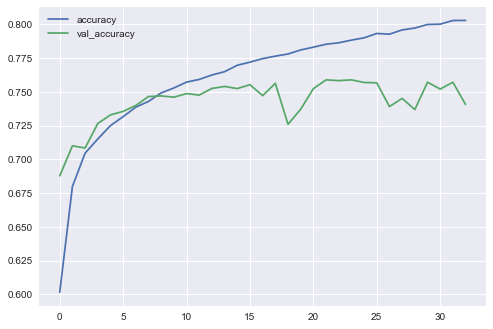

In [19]:
metrics[['accuracy','val_accuracy']].plot()
plt.savefig('../figures/cnn_glove50_acc.jpg', dpi=300)

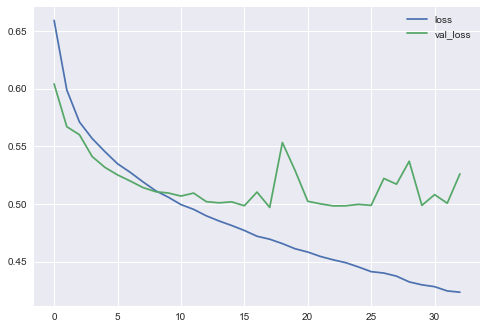

In [20]:
metrics[['loss','val_loss']].plot()
plt.savefig('../figures/cnn_glove50_loss.jpg', dpi=300)

In [21]:
# Evaluation on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

32000/32000 [==============================] - 1s 38us/step


In [22]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

Test loss: 0.49952391082048414
Test accuracy: 0.753531277179718
Test precision: 0.7654238939285278
Test recall: 0.7261627316474915


In [23]:
model.save('../models/cnn_glove50.h5')